In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import cv2 
import kagglehub 

/home/chloycosta/Documents/College_code/Sem_5/NNDL/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print("Downloading dataset from KaggleHub...")
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print(f"Dataset downloaded to: {path}")

train_dir = os.path.join(path, 'seg_train/seg_train')
test_dir = os.path.join(path, 'seg_test/seg_test')

if not os.path.exists(train_dir):
    print(f"ERROR: Train directory not found at {train_dir}")
elif not os.path.exists(test_dir):
    print(f"ERROR: Test directory not found at {test_dir}")
else:
    print("Train and Test directories found successfully.")

100%|██████████| 346M/346M [00:46<00:00, 7.82MB/s] 

Extracting files...


Dataset downloaded to: /home/chloycosta/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2
Train and Test directories found successfully.


Found 6 classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


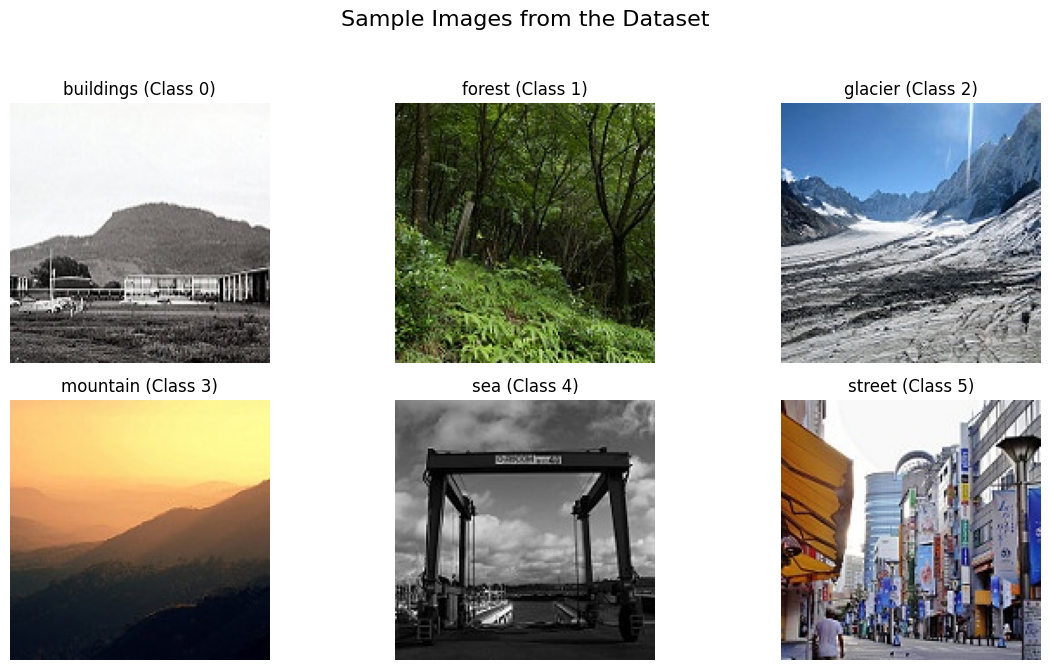

In [ ]:
class_names = sorted(os.listdir(train_dir))
print(f"Found {len(class_names)} classes: {class_names}")

plt.figure(figsize=(12, 7))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    
    first_image_file = os.listdir(class_path)[0]
    img_path = os.path.join(class_path, first_image_file)
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"{class_name} (Class {i})")
    plt.axis('off')

plt.suptitle("Sample Images from the Dataset", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
NUM_CLASSES = 6

train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values from 0-255 to 0-1
    rotation_range=20,          # Randomly rotate images
    width_shift_range=0.2,      # Randomly shift width
    height_shift_range=0.2,     # Randomly shift height
    horizontal_flip=True,       # Randomly flip horizontally
    zoom_range=0.2,             # Randomly zoom
    fill_mode='nearest'
)

# 2. Test Data Generator (NO Augmentation, only normalization)
# We must not augment the test data; we want to evaluate the model
# on the *original* test images.
test_datagen = ImageDataGenerator(
    rescale=1./255  # Only normalize
)

# 3. Create the Generators from Directories
# This automatically handles splitting the data and creating one-hot labels.
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical' # For categorical_crossentropy
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Important: Keep shuffle=False for evaluation
)

print("\nClass indices (from generator):")
print(train_generator.class_indices)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.

Class indices (from generator):
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [8]:
model = Sequential()

# Input Layer (150x150x3)
model.add(Input(shape=(150, 150, 3)))

# --- Convolutional Block 1 ---
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# --- Convolutional Block 2 ---
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# --- Convolutional Block 3 ---
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# --- Convolutional Block 4 (Extra layer for depth) ---
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# --- Classifier Head (Dense Layers) ---
model.add(Flatten()) # Unroll the 3D feature map into a 1D vector

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization()) # Stabilize the dense layer
model.add(Dropout(0.5)) # Prevent overfitting in the classifier

# --- Output Layer ---
model.add(Dense(NUM_CLASSES, activation='softmax')) # 6 classes, softmax for probabilities

# Print the model summary
model.summary()

2025-11-10 19:11:41.970466: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-11-10 19:11:42.629454: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 21233664 exceeds 10% of free system memory.
2025-11-10 19:11:42.639169: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 21233664 exceeds 10% of free system memory.
2025-11-10 19:11:42.645392: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 21233664 exceeds 10% of free system memory.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,556,294 (21.20 MB)

 Trainable params: 5,554,566 (21.19 MB)

 Non-trainable params: 1,728 (6.75 KB)

## Justification for Architecture

- Conv2D Layers: We use four convolutional blocks. The filters (32, 64, 128) increase in number to learn progressively more complex features (edges -> textures -> parts of objects). We use a (3, 3) kernel, which is a modern, efficient standard.

- relu Activation: Chosen because it's fast and prevents the "vanishing gradient" problem, allowing error signals (backpropagation) to flow effectively.

- MaxPooling2D: Used after each block to downsample the feature maps. This reduces the number of parameters and makes the model robust to the location of features in the image.

- BatchNormalization: Added after each Conv2D and Dense layer. It normalizes the output of the layer, which dramatically stabilizes training, speeds up convergence, and acts as a regularizer.

- Dropout(0.5): Added to the dense classifier to prevent overfitting. It randomly "drops" 50% of the neurons, forcing the network to learn redundant representations.

- Dense(6, 'softmax'): The output layer must have 6 neurons (one per class) and softmax activation to produce a probability distribution for our multi-class problem.

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

early_stopper = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2
)

steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

print("\n--- Starting Model Training ---")

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50, 
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopper, lr_scheduler]
)

print("\n--- Model Training Complete ---")

/home/chloycosta/Documents/College_code/Sem_5/NNDL/.venv/lib64/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



--- Starting Model Training ---
Epoch 1/50


2025-11-10 19:11:45.978756: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 21233664 exceeds 10% of free system memory.
2025-11-10 19:11:46.071627: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 21233664 exceeds 10% of free system memory.


438/438 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - accuracy: 0.6123 - loss: 1.1226 - val_accuracy: 0.5040 - val_loss: 1.7043 - learning_rate: 0.0010
Epoch 2/50
  1/438 ━━━━━━━━━━━━━━━━━━━━ 7:18 1s/step - accuracy: 0.7188 - loss: 0.5855

/home/chloycosta/Documents/College_code/Sem_5/NNDL/.venv/lib64/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


438/438 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.7188 - loss: 0.5855 - val_accuracy: 0.4956 - val_loss: 1.8260 - learning_rate: 0.0010
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.7121 - loss: 0.7980 - val_accuracy: 0.7147 - val_loss: 0.7933 - learning_rate: 0.0010
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.5312 - loss: 1.3979 - val_accuracy: 0.7268 - val_loss: 0.7556 - learning_rate: 0.0010
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 457s 1s/step - accuracy: 0.7481 - loss: 0.6931 - val_accuracy: 0.6919 - val_loss: 0.8899 - learning_rate: 0.0010
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.7812 - loss: 0.5133 - val_accuracy: 0.7006 - val_loss: 0.8620 - learning_rate: 0.0010
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.8023 - loss: 0.5587 - val_accuracy: 0.7883 - val_loss: 0.5897 - learning_rate: 2.0000e-04
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.9375 - loss: 0.336

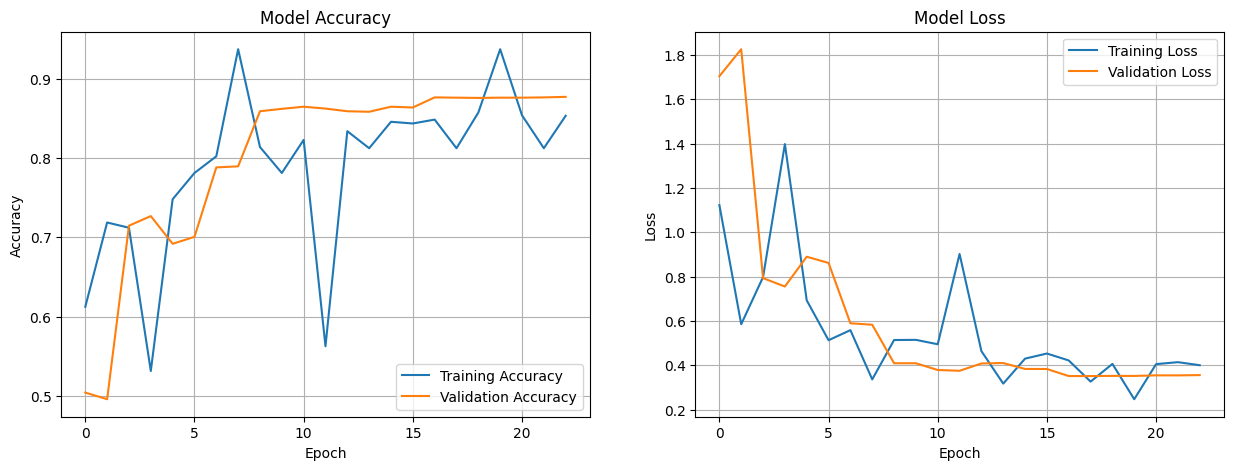

In [ ]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.show()

plot_history(history)

In [ ]:
print("\n--- Final Model Evaluation on Test Set ---")
test_loss, test_accuracy = model.evaluate(validation_generator, steps=validation_steps)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


--- Final Model Evaluation on Test Set ---
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.8763 - loss: 0.3515
Test Loss: 0.3515
Test Accuracy: 87.63%


94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step

--- Classification Report ---
              precision    recall  f1-score   support

   buildings       0.84      0.87      0.85       437
      forest       0.95      0.98      0.96       474
     glacier       0.84      0.84      0.84       553
    mountain       0.86      0.79      0.83       525
         sea       0.88      0.91      0.89       510
      street       0.88      0.89      0.88       501

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000


--- Confusion Matrix ---


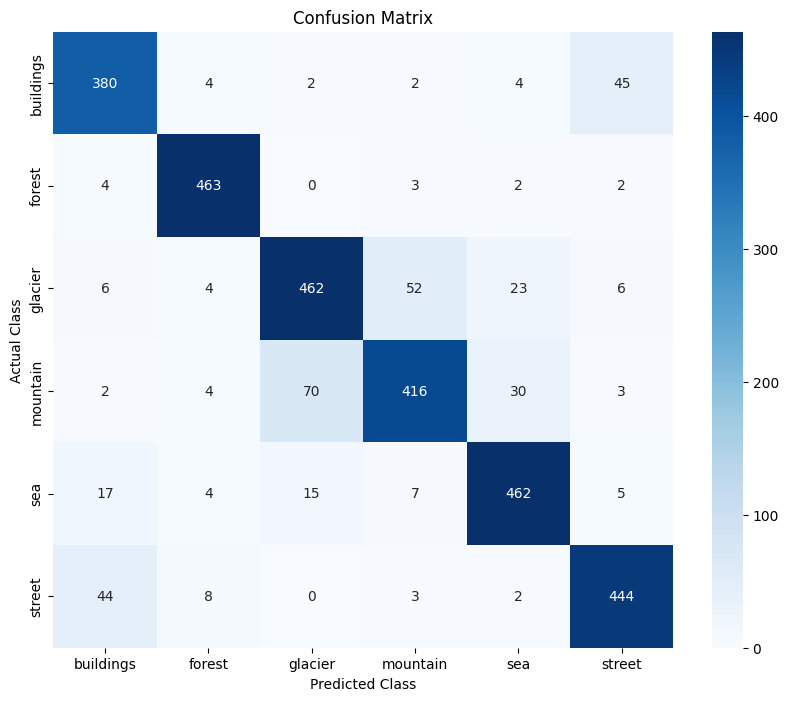

In [ ]:
y_test_classes = validation_generator.classes



steps_for_predict = int(np.ceil(validation_generator.samples / BATCH_SIZE))
y_pred_probs = model.predict(validation_generator, steps=steps_for_predict)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

y_test_classes = y_test_classes[:len(y_pred_classes)]

class_labels = list(validation_generator.class_indices.keys())

# --- Classification Report ---
print("\n--- Classification Report ---")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_labels))

# --- Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [14]:

model_filename = "intel_image_classifier.keras"
model.save(model_filename)

print(f"\nModel saved successfully to {model_filename}")


Model saved successfully to intel_image_classifier.keras
